# Jupyter Notebook Summary

This Jupyter Notebook performs noise space analysis on HIV expression data measured by FACS.
To run it, you will need a python environment (created e.g. with conda, pyenv or venv) with the packages from requirements.txt installed. 

Below is a summary of the notebook contents:

1. **Import required modules**
    - Modules such as `os`, `numpy`, `pandas`, `matplotlib`, `seaborn`, `statsmodels`, `imageio`, and `sklearn` are imported.

2. **Define functions**
    - `load_dfs(file_paths: list) -> list`: Loads multiple dataframes from a list of file paths.
    - `format_dfs(source_dfs: list, gates: list) -> list`: Formats dataframes by resampling and interpolating mean and CV values for specified gates.
    - `generate_noise_spaces(gates: list, source_dfs: dict, clone_groups: pd.Series) -> pd.DataFrame`: Generates noise spaces for given gates and source dataframes.
    - `scale_noise_space(noise_space_df: pd.DataFrame, X: str, Y: str, Z: str) -> pd.DataFrame`: Scales specified columns of a noise space DataFrame using `StandardScaler`.
    - `animate_noise_space(scaled_noise_space: pd.DataFrame, gate: str, group_colors: dict = None, name: str = "") -> None`: Generates a 3D animation of the noise space and saves it as an MP4 file.

3. **Provide data set information**
    - `GATES`: List of FACS gates to be analyzed.
    - `INPUT_FILE_PATHS`: Paths to the input files.
    - `GROUP_COLORS`: Colors for each group of clones.

4. **Generate noise space for selected data and save as CSV**
    - Load dataframes from input files and define clone groups.
    - Format dataframes by resampling and interpolating mean and CV values for specified gates.
    - Calculate noise spaces for specified gates and save results to a CSV file.

5. **Plot noise space in 3D and save animated plots**
    - Scale and animate noise spaces for noise T1/2 and fluorescence T1/2 for each gate.
    - Save the animated plots as MP4 files.

1. Import required modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import imageio.v3 as iio
from sklearn.preprocessing import StandardScaler
import statsmodels.tsa.stattools

2. Define functions

In [2]:
def load_dfs(file_paths: list) -> list:
    """
    Load multiple dataframes from a list of file paths.

    Args:
        file_paths (list): A list of file paths to the CSV files.

    Returns:
        list: A list of pandas DataFrames loaded from the provided file paths.
    """
    source_dfs = []
    clone_groups = pd.Series()
    for path in file_paths:
        in_df = pd.read_csv(path, sep="\t", index_col=["Date", "Clone"])
        source_dfs.append(in_df)
        clone_groups = pd.concat(
            [clone_groups, in_df["Group"].groupby("Clone").first()]
        )
    return source_dfs, clone_groups


def format_dfs(source_dfs: list, gates: list) -> list:
    """
    Formats a list of dataframes by resampling and interpolating mean and CV values for specified gates.

    Parameters:
    source_dfs (list): A list of pandas DataFrames, each containing 'Mean' and 'CV' columns,
                       and optionally 'Mean.<gate>' and 'CV.<gate>' columns for each gate.
    gates (list): A list of gate names (strings). If 'gated' is included, it will process the 'Mean' and 'CV' columns directly.

    Returns:
    list: A list of dictionaries, each containing the resampled and interpolated mean and CV DataFrames for each gate.
    """
    formatted_dfs = []
    for source_df in source_dfs:
        dfs_by_gate = {}
        for gate in gates:
            if gate == "gated":
                means = source_df["Mean"].unstack(level=1)
                cvs = source_df["CV"].unstack(level=1)
                means.index = pd.to_datetime(means.index)
                means.index = means.index - means.index[0]
                means = means.resample("1d").interpolate(method="linear")
                cvs.index = pd.to_datetime(cvs.index)
                cvs.index = cvs.index - cvs.index[0]
                cvs = cvs.resample("1d").interpolate(method="linear")
                dfs_by_gate[gate] = (means, cvs)
            else:
                means = source_df[f"Mean.{gate}"].unstack(level=1)
                cvs = source_df[f"CV.{gate}"].unstack(level=1)
                means.index = pd.to_datetime(means.index)
                means.index = means.index - means.index[0]
                means = means.resample("1d").interpolate(method="linear")
                cvs.index = pd.to_datetime(cvs.index)
                cvs.index = cvs.index - cvs.index[0]
                cvs = cvs.resample("1d").interpolate(method="linear")
                dfs_by_gate[gate] = (means, cvs)
        formatted_dfs.append(dfs_by_gate)
    return formatted_dfs


def generate_noise_spaces(
    gates: list, source_dfs: dict, clone_groups: pd.Series
) -> pd.DataFrame:
    """
    Generate noise spaces for given gates and source dataframes.

    Parameters:
    gates (list): List of gate names.
    source_dfs (dict): Dictionary where keys are gate names and values are tuples of DataFrames.
                       The first DataFrame contains fluorescence mean data and the second contains fluorescence noise data.
    clone_groups (pd.Series): Series containing group information for each clone.

    Returns:
    pd.DataFrame: DataFrame containing calculated noise spaces with columns for log2 of fluorescence mean (log2mean),
    squared coefficient of variation of fluorescence (CV2), noise half autocorrelation time (noise_T1/2),
    and fluorescence half autocorrelation time (fluo_T1/2) for each gate.
    """

    columns = [
        (f"{gate}_log2mean", f"{gate}_CV2", f"{gate}_pb_CV2", f"{gate}_noise_T1/2", f"{gate}_fluo_T1/2")
        for gate in gates
    ]
    columns = [elem for group in columns for elem in group]

    noise_space = pd.DataFrame(
        0,
        index=source_dfs[gates[0]][0].columns,
        columns=columns,
        dtype=float,
    )
    noise_space["Group"] = clone_groups

    for gate in gates:
        # Convert fluorescence mean to log2 scale (log2mean).
        # Calculate fluorescence CV2, defined as (std/mean)^2.
        # Calculate population based CV2 as the mean CV at each timepoint.
        noise_space[f"{gate}_log2mean"] = np.log2(source_dfs[gate][0].mean())
        noise_space[f"{gate}_CV2"] = (
            source_dfs[gate][0].std() / source_dfs[gate][0].mean()
        ) ** 2
        noise_space[f"{gate}_pb_CV2"] = ((source_dfs[gate][1]/100).mean()) ** 2

        # Calculate noise and fluorescence autocorrelation functions.
        # Fluorescence autocorrelation is calculated for mean fluorescence data.
        # Noise autocorrelation is calculated for mean-centered noise data, i.e. CV values of fluorescence for each clone at every time point
        # are subtracted by the mean CV value of that clone.
        fluo_acfs = {}
        for clone in source_dfs[gate][1].columns:
            fluo_acfs[clone] = statsmodels.tsa.stattools.acf(source_dfs[gate][0][clone])

        noise_acfs = {}
        for clone in source_dfs[gate][1].columns:
            noise_acfs[clone] = statsmodels.tsa.stattools.acf(
                source_dfs[gate][1][clone] - source_dfs[gate][1][clone].mean()
            )

        # Calculate noise and fluorescence half autocorrelation times (T1/2).
        # Half autocorrelation time is defined as the first lag where the autocorrelation function drops below 0.5.
        for clone, acf in noise_acfs.items():
            for lag, corr in enumerate(acf):
                if corr <= 0.5:
                    noise_space.loc[clone, f"{gate}_noise_T1/2"] = lag
                    break
        for clone, acf in fluo_acfs.items():
            for lag, corr in enumerate(acf):
                if corr <= 0.5:
                    noise_space.loc[clone, f"{gate}_fluo_T1/2"] = lag
                    break
    noise_space = noise_space.sort_index()
    return noise_space


def scale_noise_space(
    noise_space_df: pd.DataFrame, X: str, Y: str, Z: str
) -> pd.DataFrame:
    """
    Scales the specified columns of a noise space DataFrame using StandardScaler.
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data to be scaled.
    X (str): The name of the first column to be scaled.
    Y (str): The name of the second column to be scaled.
    Z (str): The name of the third column to be scaled.
    Returns:
    pd.DataFrame: A new DataFrame with the scaled values of the specified columns and the original 'group' column.
    """

    scaler = StandardScaler()
    scaled_noise_space = pd.DataFrame(
        scaler.fit_transform(noise_space_df[[X, Y, Z]]),
        index=noise_space_df.index,
        columns=[X, Y, Z],
    )

    scaled_noise_space["Group"] = noise_space_df["Group"]
    return scaled_noise_space


def animate_noise_space(
    scaled_noise_space: pd.DataFrame,
    gate: str,
    group_colors: dict = None,
    name: str = "",
) -> None:
    """
    Generates a 3D animation of the noise space and saves it as an MP4 file.

    Parameters:
    scaled_noise_space (pd.DataFrame): A DataFrame containing the scaled noise space data with at least three columns for the 3D plot.
    gate (str): A string identifier for the gate used in the file naming.
    group_colors (dict, optional): A dictionary mapping group names to colors. If None, a default color palette is used. Defaults to None.
    name (str, optional): An additional string identifier for the file naming. Defaults to an empty string.

    Returns:
    None
    """
    fig = plt.figure(figsize=(10, 5.625))
    ax = fig.add_subplot(111, projection="3d")
    X = scaled_noise_space.iloc[:, 0]
    Y = scaled_noise_space.iloc[:, 1]
    Z = scaled_noise_space.iloc[:, 2]
    if group_colors is None:
        group_colors = {
            group: sns.color_palette("tab20")[i]
            for i, group in enumerate(scaled_noise_space["Group"].unique())
        }
    colors = [group_colors[group] for group in scaled_noise_space["Group"]]
    ax.scatter(X, Y, Z, c=colors, alpha=1, s=200)
    ax.set_title("Sinpro clones in expression noise space")
    ax.set_xlabel(scaled_noise_space.columns[0])
    ax.set_ylabel(scaled_noise_space.columns[1])
    ax.set_zlabel(scaled_noise_space.columns[2])
    fig.tight_layout()
    frames_paths = []
    for angle in np.linspace(270, 359, 120):
        ax.view_init(30, angle)
        plt.draw()
        if os.path.exists(f"anim/{gate}_{name}") == False:
            os.makedirs(f"anim/{gate}_{name}")
        frame_path = f"anim/{gate}_{name}/{gate}{angle}.png"
        plt.savefig(frame_path, format="png", dpi=72)
        frames_paths.append(frame_path)

    frames = []
    for frame in frames_paths:
        frames.append(iio.imread(frame))
    for frame in reversed(frames):
        frames.append(frame)
    iio.imwrite(
        f"anim/{gate}_{name}.mp4",
        frames,
        plugin="pyav",
        codec="libx264",
        in_pixel_format="rgba",
        out_pixel_format="yuv444p",
        fps=30,
    )

3. Provide data set information

In [3]:
# GATES defines the FACS gates to be analyzed
GATES = ["gated", "live"]

# INPUT_FILE_PATHS defines the paths to the input files
INPUT_FILE_PATHS = ["input/SuppTable1.txt", "input/SuppTable3.txt"]

# GROUP_COLORS defines the colors for each group of clones
GROUP_COLORS = {"S":"black", "A-":"orange", "A":"red", "F_neg":"grey", "F_pos":"green", "F":"palegreen"}

4. Generate noise space for selected data and save as csv.

In [4]:
# Load the dataframes from the input files and define the clone groups
source_dfs, clone_groups = load_dfs(INPUT_FILE_PATHS)

# Format the dataframes by resampling and interpolating mean and CV values for the specified gates
formatted_dfs = format_dfs(source_dfs, GATES)

# Calculate the noise spaces for the specified gates
noise_spaces = []
for df in formatted_dfs:
    noise_spaces.append(generate_noise_spaces(GATES, df, clone_groups))
noise_space = pd.concat(noise_spaces)
noise_space.to_csv("output/SuppTable4.txt", sep="\t")
noise_space.head()

,gated_log2mean,gated_CV2,gated_pb_CV2,gated_noise_T1/2,gated_fluo_T1/2,live_log2mean,live_CV2,live_pb_CV2,live_noise_T1/2,live_fluo_T1/2,Group
Clone,,,,,,,,,,,
758,12.880532,0.146797,2.248334,6.0,7.0,11.230663,0.518742,9.744803,3.0,6.0,A-
760,12.141477,0.049508,1.334667,5.0,6.0,11.730806,0.173372,2.309134,7.0,7.0,A-
761,10.874875,0.069780,1.284570,3.0,6.0,9.814315,0.284012,2.690056,2.0,7.0,A-
762,11.502493,0.009226,1.021896,2.0,3.0,11.352856,0.012971,1.217957,3.0,3.0,A
764,12.935996,0.082149,1.613253,3.0,7.0,10.327740,0.626899,15.015625,5.0,6.0,A-


5. Plot noise space in 3d and save animated plots.

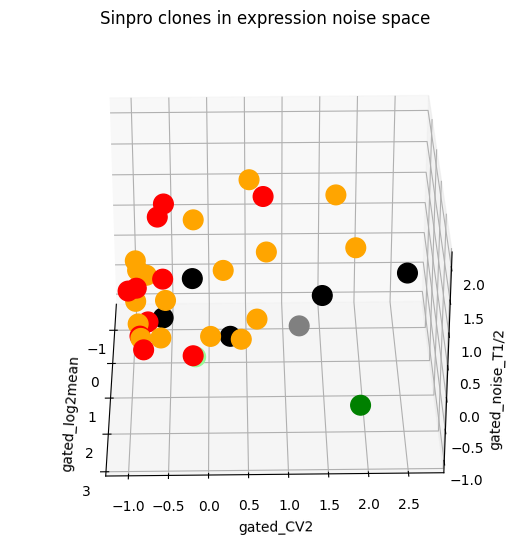

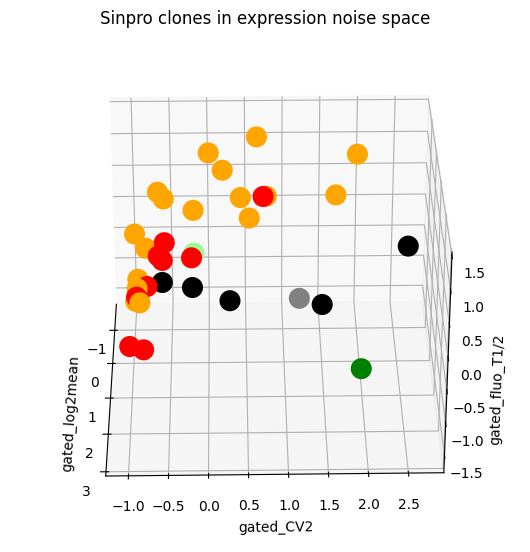

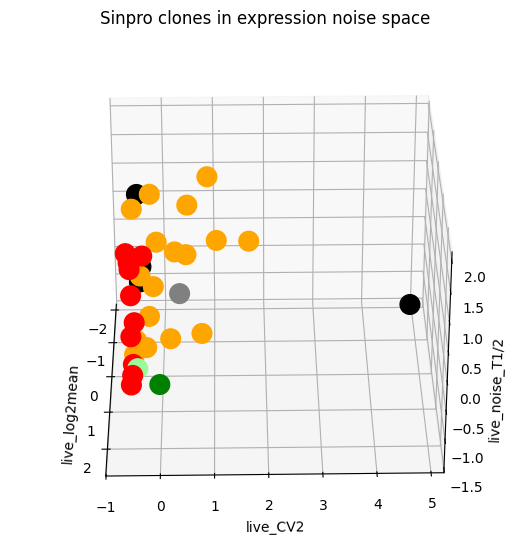

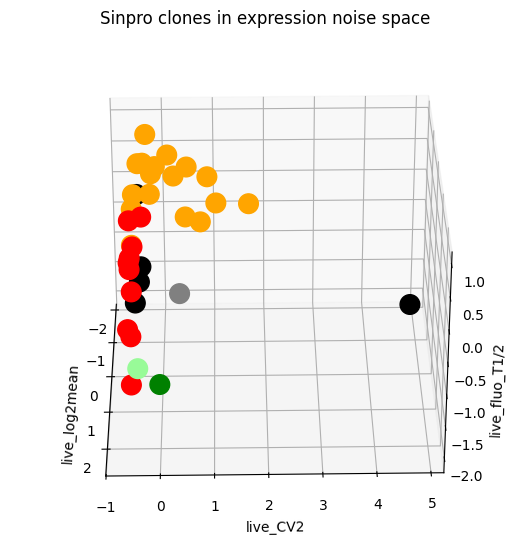

In [5]:
# Define dictionaries to store the scaled noise spaces for noise T1/2 and fluorescence T1/2
noiseT_spaces = {}
fluoT_spaces = {}

for gate in GATES:
    # Scale and animate the noise spaces for noise T1/2
    noiseT_spaces[gate] = scale_noise_space(noise_space, f"{gate}_log2mean", f"{gate}_CV2", f"{gate}_noise_T1/2")
    animate_noise_space(noiseT_spaces[gate], gate, group_colors=GROUP_COLORS, name="noiseT")

    # Scale and animate the noise spaces for fluorescence T1/2
    fluoT_spaces[gate] = scale_noise_space(noise_space, f"{gate}_log2mean", f"{gate}_CV2", f"{gate}_fluo_T1/2")
    animate_noise_space(fluoT_spaces[gate], gate, group_colors=GROUP_COLORS, name="fluoT")
